In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sample_batch = torch.randint(0,3,(32,1000))
sample_batch.shape #(bs,seq_len)

torch.Size([32, 1000])

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## DanQ

In [4]:
class DanQ(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb  = nn.Embedding(4,8) # in original DanQ the input is one-hot encoded, aka not learnable
        self.conv = nn.Conv1d(8,320,26,padding=0)
        self.pool = nn.MaxPool1d(13,13)
        self.drop1= nn.Dropout(0.2)
        
        self.lstm = nn.LSTM(320,320,bidirectional=True)
        self.drop2= nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(640*75,928)
        self.fc2 = nn.Linear(928,919)
        
    def forward(self,x):                  #(bs, 1000)
        x = self.emb(x)                   #(bs, 1000, 8)
        #Conv1d
        x = x.permute(0,2,1).contiguous() #(bs, 8, 1000)
        x = F.relu(self.conv(x))          #(bs, 320, 975)
        x = self.drop1(self.pool(x))      #(bs, 320, 75)
        #LSTM
        x = x.permute(0,2,1).contiguous() #(bs, 75, 320)
        x,h = self.lstm(x)                #(bs, 75, 640)
        x = self.drop2(x)
        #FC
        x = x.view(x.shape[0],-1)         #(bs,75*640)
        x = F.relu(self.fc1(x))           #(bs,928)
        x = self.fc2(x)                   #(bs,919)
        return x # return logits instead of sigmoid

In [20]:
DanQ()(sample_batch)

tensor([[-0.0357, -0.0567,  0.0217,  ..., -0.0666,  0.0227, -0.0358],
        [-0.0108, -0.0384, -0.0049,  ..., -0.0860,  0.0194,  0.0612],
        [ 0.0052, -0.0615,  0.1294,  ..., -0.0312, -0.0188, -0.0219],
        ...,
        [-0.0814, -0.0535,  0.0219,  ..., -0.1294, -0.0508,  0.0013],
        [ 0.0387, -0.0681,  0.0043,  ...,  0.0185,  0.0054,  0.0723],
        [ 0.0109, -0.0565,  0.0481,  ..., -0.0467, -0.0712,  0.0494]],
       grad_fn=<AddmmBackward>)

In [5]:
count_parameters(DanQ())

47109111

## Transformer XL

In [4]:
import transformers as ts

In [12]:
cfg = ts.TransfoXLConfig(vocab_size=4, d_model=64, d_embed=8, n_head=4, d_head=16, d_inner=128, 
                             n_layer=6, tgt_len=0, ext_len=0, mem_len=512, cutoffs=[1], )
model = ts.TransfoXLModel(cfg)

In [13]:
count_parameters(model)

225294

In [7]:
last_hidden_state,  mems = model(sample_batch)

In [15]:
last_hidden_state.shape, mems[0].shape

(torch.Size([8, 1000, 64]), torch.Size([512, 8, 64]))

In [ ]:
def TransXL_LM(nn.Module):
    def __init__(self,):
        self.cfg = ts.TransfoXLConfig(vocab_size=4, d_model=512, d_embed=8, n_head=8, d_head=64, 
                                 d_inner=2048, n_layer=6, tgt_len=0, ext_len=0, mem_len=512, cutoffs=[1], )
        self.core = ts.TransfoXLModel(cfg)
        self.lm_head = nn.Linear(self.cfg.d_model,self.cfg.vocab_size)
        
    def forward(self,x,mems=None):
        input = x[:-1]
        target= x[1:]
        for i in range(x.shape[1]//self.cfg.mem_len)
            #todo break x
            last_hidden_state,  mems = self.core(x,mems)
            self.lm_head(last_hidden_state)

## Resnet + TransformerXL

In [4]:
import transformers as ts

In [5]:
class ConvBN(nn.Module):
    # https://arxiv.org/pdf/1603.05027.pdf 
    def __init__(self,inp_dim,out_dim,ks=1,pad=0,stride=1):
        super().__init__()
        self.bn = nn.BatchNorm1d(inp_dim)
        self.cv = nn.Conv1d(inp_dim,out_dim, kernel_size=ks, padding=pad,stride=stride,bias=False)
    def forward(self, x): return self.cv(F.relu(self.bn(x)))
    
    
class ResBlock1D(nn.Module):
    def __init__(self,out_dim,first_stride=2,k=1):
        super().__init__()
        width = int(k * out_dim//4) # https://arxiv.org/abs/1605.07146
        self.cvbn1 = ConvBN(out_dim//2, width,stride=first_stride) #(bs,inp_dim,seq_len)
        self.cvbn2 = ConvBN(width,      width,3,1)
        self.cvbn3 = ConvBN(width,      out_dim)
        self.id    = ConvBN(out_dim//2, out_dim,stride=first_stride)
        
    def forward(self,inp):
        x = self.cvbn1(inp)
        x = self.cvbn2(x)
        x = self.cvbn3(x)
        return x + self.id(inp)
         
    
class Resnet1D(nn.Module):
    def __init__(self,n_blocks,emb_dim,d_model,k=1):
        super().__init__()
        self.out_seq_len = int(1000/2**n_blocks)
        assert d_model%2**n_blocks==0                           # n_blocks = 3
                                                                # (bs,8,1000) input
        layers =[nn.Conv1d(emb_dim,d_model//2**n_blocks,7,1,3,bias=False)] # (bs,64,1000)

        for i in range(n_blocks,0,-1):
            out_dim = d_model//2**(i-1)
            layers.append(ResBlock1D(out_dim,k=k))                  # (bs, d_model//2**(i-1), seq_len/i)
        self.layers = nn.Sequential(*layers)
        self.RBN = nn.Sequential(nn.BatchNorm1d(d_model),nn.ReLU(inplace=True))
    def forward(self, x): return self.RBN(self.layers(x))
    
    
class ResTransXLHead(nn.Module):
    def __init__(self,inp_dim,hid_dim=512,p=0.3,WVN=False):
        super().__init__()
        layers = []
        if hid_dim!=0:
            layers = [ 
                nn.Linear(inp_dim,hid_dim,bias=False),
                nn.BatchNorm1d(hid_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(p)
            ]
        else: hid_dim = inp_dim

        self.fc_end = nn.Linear(hid_dim,919)
        self.init_umbalanced()
        layers.append(self.fc_end)
        self.layers = nn.Sequential(*layers)
        
        if WVN:
            #https://arxiv.org/pdf/1912.01857.pdf
            self.fc_end.register_backward_hook(self.__WVN__)

    def __WVN__(self, module, grad_input, grad_output):
        W = module.weight.data
        W_norm = W / torch.norm(W, p=2, dim=1, keepdim=True)
        module.weight.data.copy_(W_norm)
        
    def init_umbalanced(self):
        # https://arxiv.org/pdf/1901.05555.pdf
        pi = torch.tensor(2/100) #prob of positive class
        b = -torch.log((1-pi)/pi)
        nn.init.constant_(self.fc_end.bias,b)
        
    def forward(self, x): return self.layers(x) 
    
    
class ResTransXL(nn.Module):
    def __init__(self,vocab_size,d_emb, tsfm_cfg, n_res_blocks=3,res_k=1, res_p=0.2, 
                 skip_cnt=False, fc_h_dim=512,lin_p=0.3, WVN=False,LSTM=True,LSTM_p=0.5):
        super(ResTransXL, self).__init__()
        self.LSTM = LSTM
        self.emb = nn.Embedding(vocab_size,d_emb)
        self.res = Resnet1D(n_res_blocks,d_emb,tsfm_cfg.d_model,k=res_k)
        self.res_drop = nn.Dropout(res_p)
        self.cfg = tsfm_cfg
        if LSTM: 
            self.core = nn.LSTM(tsfm_cfg.d_model,tsfm_cfg.d_model,bidirectional=True,batch_first=True)
            self.core_drop = nn.Dropout(LSTM_p)
        else: self.core = ts.TransfoXLModel(tsfm_cfg)
        self.skip_cnt = skip_cnt
        self.lin_inp_dim = self.res.out_seq_len * tsfm_cfg.d_model *(1 + skip_cnt + LSTM)
        self.lm_head = ResTransXLHead(self.lin_inp_dim,fc_h_dim,p=lin_p,WVN=False)
        
    def summary(self):
        print(f'Model parameters:\t\t\t\t')
        print(f'Resnet part:\t\t{count_parameters(self.res)//1000}k')
        print(f'Transformer-XL part:\t{count_parameters(self.core)//1000}k')
        print(f'Linear part:\t\t{count_parameters(self.lm_head)//1000}k')
        print(f'Total:\t\t\t{count_parameters(self)//1000}k')
        
    def forward(self,x,mems=None):
        x = self.emb(x)                   #(bs, 1000, d_emb)
        x = x.permute(0,2,1).contiguous() #(bs, d_emb, 1000)
        
        x = self.res(x)                   #(bs, d_model,125)
        x = self.res_drop(x)
        x = x.permute(0,2,1).contiguous() #(bs, 125, d_model)
        
        if self.LSTM: 
            last_h, _ = self.core(x)            # (bs, seq_len, num_directions * hidden_size)
            last_h = self.core_drop(last_h)
        else: last_h,  mems = self.core(inputs_embeds=x,mems=mems) #(bs, 125, d_model)
            
        if self.skip_cnt:
            lin_inp = torch.cat([x,last_h],dim=-1)
            lin_inp = lin_inp.view(-1, self.lin_inp_dim)
        else:    
            lin_inp = last_h.view(-1, self.lin_inp_dim)
        out = self.lm_head(lin_inp)
        return out, mems

In [6]:
cfg = ts.TransfoXLConfig(vocab_size=4, d_embed=8,d_model=256, n_head=4, d_head=16, d_inner=256, 
                         n_layer=6, tgt_len=0, ext_len=0, mem_len=512, cutoffs=[1], )

model = ResTransXL(vocab_size=4, d_emb=64, tsfm_cfg=cfg,skip_cnt=True,fc_h_dim=512,n_res_blocks=3,res_k=16)
model(sample_batch.cpu())[0].shape

torch.Size([32, 919])

In [7]:
model.summary()

Model parameters:				
Resnet part:		4710k
Transformer-XL part:	1052k
Linear part:		49624k
Total:			55388k


In [8]:
model

ResTransXL(
  (emb): Embedding(4, 64)
  (res): Resnet1D(
    (layers): Sequential(
      (0): Conv1d(64, 32, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (1): ResBlock1D(
        (cvbn1): ConvBN(
          (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(32, 256, kernel_size=(1,), stride=(2,), bias=False)
        )
        (cvbn2): ConvBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        )
        (cvbn3): ConvBN(
          (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(256, 64, kernel_size=(1,), stride=(1,), bias=False)
        )
        (id): ConvBN(
          (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(32, 64, kernel_size=(1,), stride=(2

### bottleneck

In [40]:
#break network in piece and pass random batches of difents size, time each part to find botleneck
#calculate teorical total batch time too

In [34]:
def profile(model,x):
        t0 = time.time()
        x = model.emb(x)                   #(bs, 1000, d_emb)
        
        t1 = time.time() - t0
        x = x.permute(0,2,1).contiguous() #(bs, d_emb, 1000)
        x = model.res(x)                   #(bs, d_model,125)
        
        t2 = time.time() - t0
        x = x.permute(0,2,1).contiguous() #(bs, 125, d_model)
        if model.LSTM: last_h, _ = model.core(x)            # (bs, seq_len, num_directions * hidden_size)
        else: last_h,  mems = model.core(inputs_embeds=x,mems=mems) #(bs, 125, d_model)
        
        t3 = time.time() - t0
        if model.skip_cnt:
            lin_inp = torch.cat([x,last_h],dim=-1)
            lin_inp = lin_inp.view(-1, model.lin_inp_dim)
        else:    
            lin_inp = last_h.view(-1, model.lin_inp_dim)
        out = model.lm_head(lin_inp) 
        t4 = time.time() - t0
        return [0,t1,t2,t3,t4]

#### d_model=256

In [17]:
cfg = ts.TransfoXLConfig(vocab_size=4, d_embed=8,d_model=256, n_head=4, d_head=16, d_inner=128, 
                         n_layer=6, tgt_len=0, ext_len=0, mem_len=512, cutoffs=[1], )

model = ResTransXL(vocab_size=4, d_emb=8, tsfm_cfg=cfg,fc_h_dim=512)
model.cuda()
model.summary()

Model parameters:				
Resnet part:		94k
Transformer-XL part:	896k
Linear part:		16855k
Total:			17847k


In [18]:
%timeit model(sample_batch.cuda())

41.2 ms ± 3.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


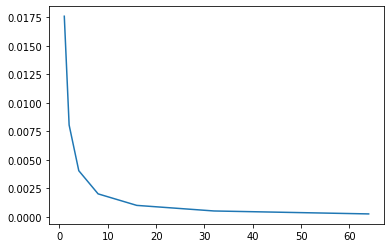

In [70]:
N = 4_400_000
t_s = []
t_ins = []
bss=[1,2,4,8,16,32,64]

for bs in bss:
    sample_batch = torch.randint(0,3,(8,1000)).cuda()
    start = time.time()
    t_in = model(sample_batch.cuda(),profile=True)
    end = time.time()
    t = (end-start)/bs
    t_s.append(t)
    t_ins.append(t_in)
    
plt.plot(bss,t_s)

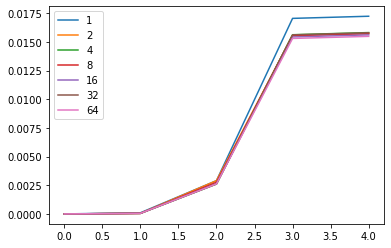

In [71]:
min_t=[]
max_t=[]
for i in range(len(bss)):
    plt.plot([0,1,2,3,4],t_ins[i])
    
plt.legend(bss)

In [72]:
np_t_ins = np.array(t_ins)
np_t_ins_difs = np_t_ins[:,1:] - np_t_ins[:,:-1]

t_max_dif = np_t_ins_difs.max(0)-np_t_ins_difs.min(0)
t_max_dif/t_max_dif.sum() * 100 # % of time discrepancy(emb,res,t-xl,fc)

array([ 2.82849061, 16.17382361, 80.45770121,  0.53998457])

#### d_model=32

In [19]:
cfg = ts.TransfoXLConfig(vocab_size=4, d_embed=8,d_model=64, n_head=4, d_head=16, d_inner=128, 
                         n_layer=6, tgt_len=0, ext_len=0, mem_len=512, cutoffs=[1], )

model = ResTransXL(vocab_size=4, d_emb=8, tsfm_cfg=cfg,fc_h_dim=512)
model.cuda()
count_parameters(model),count_parameters(model.res),count_parameters(model.core),count_parameters(model.lm_head)

(4843469, 50184, 225294, 4567959)

In [20]:
%timeit model(sample_batch.cuda())

14.2 ms ± 62.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


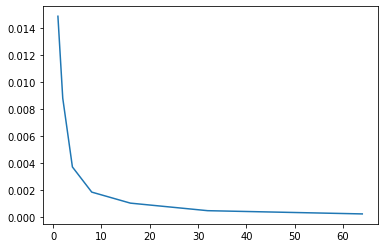

In [21]:
N = 4_400_000
t_s = []
t_ins = []
bss=[1,2,4,8,16,32,64]

for bs in bss:
    sample_batch = torch.randint(0,3,(8,1000)).cuda()
    start = time.time()
    t_in = model(sample_batch.cuda(),profile=True)
    end = time.time()
    t = (end-start)/bs
    t_s.append(t)
    t_ins.append(t_in)
    
plt.plot(bss,t_s)

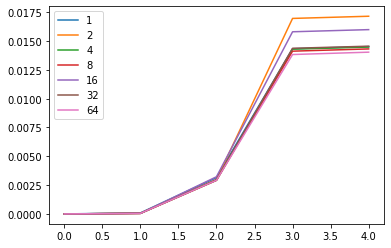

In [22]:
min_t=[]
max_t=[]
for i in range(len(bss)):
    plt.plot([0,1,2,3,4],t_ins[i])
    
plt.legend(bss)

In [23]:
np_t_ins = np.array(t_ins)
np_t_ins_difs = np_t_ins[:,1:] - np_t_ins[:,:-1]

t_max_dif = np_t_ins_difs.max(0)-np_t_ins_difs.min(0)
t_max_dif/t_max_dif.sum() * 100  # % of time discrepancy(emb,res,t-xl,fc)

array([ 1.17354687,  8.87063372, 89.31382024,  0.64199917])

#### 

In [9]:
cfg = ts.TransfoXLConfig(vocab_size=4, d_embed=8,d_model=352, n_head=4, d_head=16, d_inner=256, 
                         n_layer=6, tgt_len=0, ext_len=0, mem_len=256, cutoffs=[1], )

model = ResTransXL(vocab_size=4, d_emb=64, tsfm_cfg=cfg,skip_cnt=True,fc_h_dim=256,n_res_blocks=3, res_k=16
                   ,LSTM=True)
# model.cuda()
model.summary()

Model parameters:				
Resnet part:		8894k
Transformer-XL part:	1988k
Linear part:		34028k
Total:			44911k


In [10]:
model

ResTransXL(
  (emb): Embedding(4, 64)
  (res): Resnet1D(
    (layers): Sequential(
      (0): Conv1d(64, 44, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (1): ResBlock1D(
        (cvbn1): ConvBN(
          (bn): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(44, 352, kernel_size=(1,), stride=(2,), bias=False)
        )
        (cvbn2): ConvBN(
          (bn): BatchNorm1d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(352, 352, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        )
        (cvbn3): ConvBN(
          (bn): BatchNorm1d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(352, 88, kernel_size=(1,), stride=(1,), bias=False)
        )
        (id): ConvBN(
          (bn): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (cv): Conv1d(44, 88, kernel_size=(1,), stride=(2

In [58]:
%timeit model(sample_batch.cuda())

19.7 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


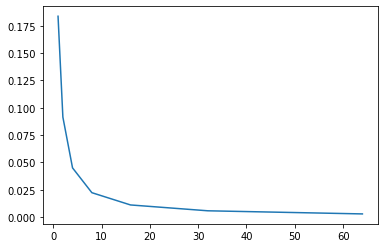

In [45]:
N = 4_400_000
t_s = []
t_ins = []
bss=[1,2,4,8,16,32,64]

for bs in bss:
    sample_batch = torch.randint(0,3,(8,1000))#.cuda()
    start = time.time()
    t_in = profile(model,sample_batch)
    end = time.time()
    t = (end-start)/bs
    t_s.append(t)
    t_ins.append(t_in)
    
plt.plot(bss,t_s)

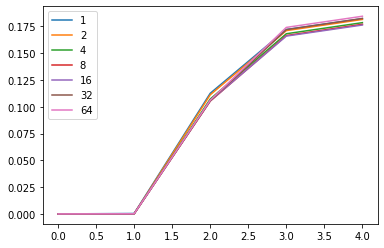

In [46]:
min_t=[]
max_t=[]
for i in range(len(bss)):
    plt.plot([0,1,2,3,4],t_ins[i])
    
plt.legend(bss)

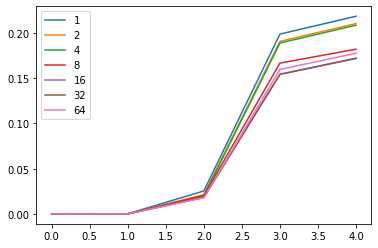

In [37]:
min_t=[]
max_t=[]
for i in range(len(bss)):
    plt.plot([0,1,2,3,4],t_ins[i])
    
plt.legend(bss)

In [38]:
np_t_ins = np.array(t_ins)
np_t_ins_difs = np_t_ins[:,1:] - np_t_ins[:,:-1]

t_max_dif = np_t_ins_difs.max(0)-np_t_ins_difs.min(0)
t_max_dif/t_max_dif.sum() * 100  # % of time discrepancy(emb,res,t-xl,fc)

array([ 0.24026492, 15.08206231, 75.82171086,  8.85596191])

## Reformer

In [14]:
import torch
from reformer_pytorch import Reformer

model = Reformer(
    emb = 128,
    depth = 6,
    max_seq_len = 1000,
    heads = 8,
    lsh_dropout = 0.1,
    causal = True
).cuda()

x = torch.randn(32, 1024, 128).cuda()
y = model(x) # (1, 1000, 512)
y.shape

torch.Size([32, 1024, 128])

In [15]:
count_parameters(model)

1089024

In [16]:
%timeit model(x)

710 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
